In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
import pickle
warnings.filterwarnings("ignore")

# Load cleaned data

In [3]:
data_folder = "/Users/iryna/Documents/GitHub/IDS-project/data/"

df = pd.read_csv(data_folder + "training_data.csv")

# clean and keep only the data we want
data =[]
data = df[['id','stars','starVotes','length','ascent','descent', 'high', 'low', 
          'longitude','latitude', 'difficulty']]

In [4]:
mapping = {'green': 1, 'greenBlue': 1, 'blue': 2, 'blueBlack': 2, 'black': 3, 'dblack': 3}
data.replace(to_replace = {'difficulty' : mapping}, inplace = True)
data.describe()

,id,stars,starVotes,length,ascent,descent,high,low,longitude,latitude,difficulty
count,2.824000e+03,2824.000000,2824.000000,2824.000000,2824.000000,2824.000000,2824.000000,2824.000000,2824.000000,2824.000000,2824.000000
mean,7.038744e+06,4.185942,7.789660,8.164837,1137.209986,-1065.430241,3837.538244,3031.027266,-97.885732,42.528836,2.033640
std,2.702557e+04,1.146773,19.438806,18.645545,2345.459481,2355.071712,3439.945213,2757.346092,15.356823,4.249339,0.683753
min,7.000000e+06,0.000000,0.000000,0.000000,0.000000,-54394.000000,0.000000,-280.000000,-121.591800,34.783200,1.000000
25%,7.016145e+06,4.000000,1.000000,1.800000,111.000000,-1105.500000,978.250000,779.750000,-111.617300,39.059575,2.000000
50%,7.035008e+06,4.500000,2.000000,4.000000,412.500000,-335.000000,2497.500000,1804.500000,-98.509300,42.551450,2.000000
75%,7.054825e+06,5.000000,6.000000,8.000000,1311.500000,-90.000000,6348.500000,5046.750000,-84.294600,45.566800,3.000000
max,7.093274e+06,5.000000,278.000000,308.300000,58094.000000,0.000000,14433.000000,12745.000000,-68.909700,53.954400,3.000000


In [10]:
# select a subset of predictor variables

data_final = data[['length','ascent','descent', 'high', 'low', 
          'longitude','latitude', 'difficulty']]

X = data_final.loc[:, data_final.columns != 'difficulty']
y = data_final.loc[:, data_final.columns == 'difficulty']


len(data_final.longitude)

2824

In [11]:
X.columns

Index(['length', 'ascent', 'descent', 'high', 'low', 'longitude', 'latitude'], dtype='object')

# Find optimal parameters and train Random Forest

In [12]:
# now, we need to split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [13]:
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm

columns = X_train.columns
os = SMOTE(random_state = 0)
os_data_X,os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X,columns = columns )
os_data_y = pd.DataFrame(data = os_data_y,columns = ['difficulty'])


In [14]:
# tune parameters for Random Forest model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier(class_weight = 'balanced')
parameters = {'n_estimators'    : sp_randInt(100, 500),
                  'max_features'    : sp_randInt(1,5),
                  'min_samples_split' : sp_randInt(5, 30),
                  'max_depth'    : sp_randInt(4, 10)
                 }

randm = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 2, n_iter = 10, n_jobs=-1)
randm.fit(os_data_X, os_data_y)

RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a20f2ecd0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a20f2e910>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a20f2e890>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a20f2e6d0>})

In [15]:
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n",
          randm.best_estimator_)
print("\n The best score across ALL searched params:\n",
          randm.best_score_)
print("\n The best parameters across ALL searched params:\n",
          randm.best_params_)
print("\n ========================================================")


 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=3,
                       min_samples_split=9, n_estimators=366)

 The best score across ALL searched params:
 0.7198040726203283

 The best parameters across ALL searched params:
 {'max_depth': 9, 'max_features': 3, 'min_samples_split': 9, 'n_estimators': 366}



In [16]:
clf = RandomForestClassifier(class_weight='balanced',max_depth=9, max_features=3,
                       min_samples_split=9, n_estimators=450)
RF_model = clf.fit(X_train, y_train)


# Cross-validating steps

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
print(" Test score is {x}".format (x =  round(RF_model.score(X_test,y_test),4)))

 Test score is 0.6686


In [19]:
# get predicted values
y_predict = RF_model.predict(X_test)

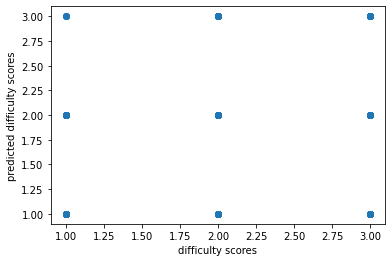

In [20]:
# plot presicted vs expected
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_predict)
plt.xlabel('difficulty scores')
plt.ylabel('predicted difficulty scores')
plt.savefig('prediction_scores_RF')
plt.show()

In [21]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': RF_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

,feature,importance
1,ascent,0.323823
2,descent,0.242859
0,length,0.128050
3,high,0.103842
4,low,0.072723


In [22]:
RF_cv_score = cross_val_score(RF_model, X, y, cv=10)

In [24]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_predict))
print('\n')
print("=== All AUC Scores ===")
print(RF_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", RF_cv_score.mean())

=== Confusion Matrix ===
[[155  50   3]
 [ 55 277  90]
 [ 14  69 135]]


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.69      0.75      0.72       208
           2       0.70      0.66      0.68       422
           3       0.59      0.62      0.61       218

    accuracy                           0.67       848
   macro avg       0.66      0.67      0.67       848
weighted avg       0.67      0.67      0.67       848



=== All AUC Scores ===
[0.67844523 0.67844523 0.50530035 0.51236749 0.42198582 0.53191489
 0.53191489 0.5177305  0.5248227  0.5212766 ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.5424203693957848


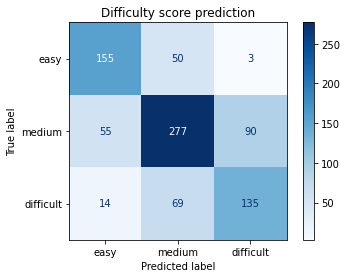

In [25]:
# plot and save confusion matrix
from sklearn.metrics import plot_confusion_matrix
class_names = ["easy", "medium", "difficult"]
disp = plot_confusion_matrix(RF_model, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title('Difficulty score prediction')
plt.savefig('ConfusionMatrix')

In [32]:
# plot a ROC curve for each class,, binarize y 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y = label_binarize(y, classes=[1, 2, 3])

n_classes = y.shape[1]
n_samples, n_features = X.shape

print(n_classes)
print(n_samples)
print(n_features)


3
2824
7


In [33]:
# Learn to predict each class against the other and split data

from sklearn.multiclass import OneVsRestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
classifier = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced',max_depth=9, max_features=4,
                       min_samples_split=7, n_estimators=481))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


In [34]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

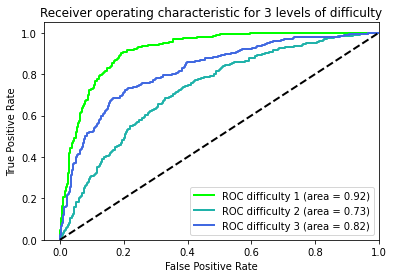

In [35]:
lw = 2
colors = ['lime', 'lightseagreen', 'royalblue', 'mediumblue', 'black', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC difficulty {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for 3 levels of difficulty')
plt.legend(loc="lower right")
plt.savefig('ROC curve')
plt.show()

# Save RF model parameters for later

In [36]:

pkl_filename = "pickle_model2.pkl"
with open(pkl_filename, 'wb') as file:   
    pickle.dump(RF_model, file)